# Fitting a spectrum model using Gradient Descent Based Optimization.

last update: Jan 22nd (2024) Hajime Kawahara

The ability of the gradient-based optimizations is s one of the major advantages of ExoJAX. Here we demonstrate how to optimize the model using jaxopt package.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

In [2]:
from jax.config import config

config.update("jax_enable_x64", True)

/tmp/ipykernel_142838/3697569592.py:1: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


Here, we use a mock CH4 spectrum precomputed by ExoJAX. Also, we normalize it and add some noise.

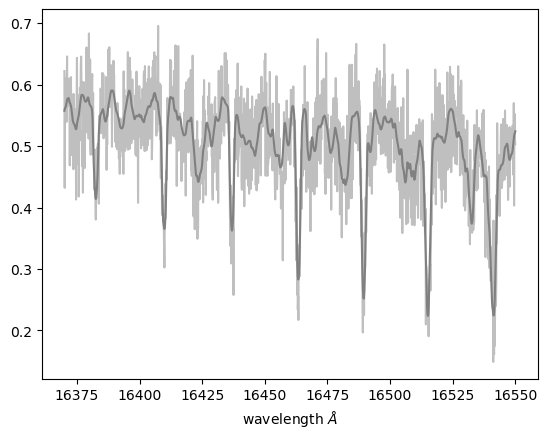

In [3]:
import pkg_resources
from exojax.spec.unitconvert import nu2wav
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW

# loading the data
filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd)

sigmain = 0.05
norm = 20000
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))


plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")
plt.plot(wavd[::-1],flux/norm,alpha=1,color="gray")

plt.xlabel("wavelength $\AA$")
plt.show()

Let’s make a model, which should be include CH4, CIA (H2-H2), spin rotation, and response… So, import everthing we need. We use PreMODIT as `opa`.

In [4]:
from exojax.utils.grids import wavenumber_grid
from exojax.spec.atmrt import ArtEmisPure
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA
from exojax.spec.specop import SopRotation
from exojax.spec.specop import SopInstProfile
from exojax.utils.instfunc import resolution_to_gaussian_std

/home/exoplanet01/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


Again recall this figure.

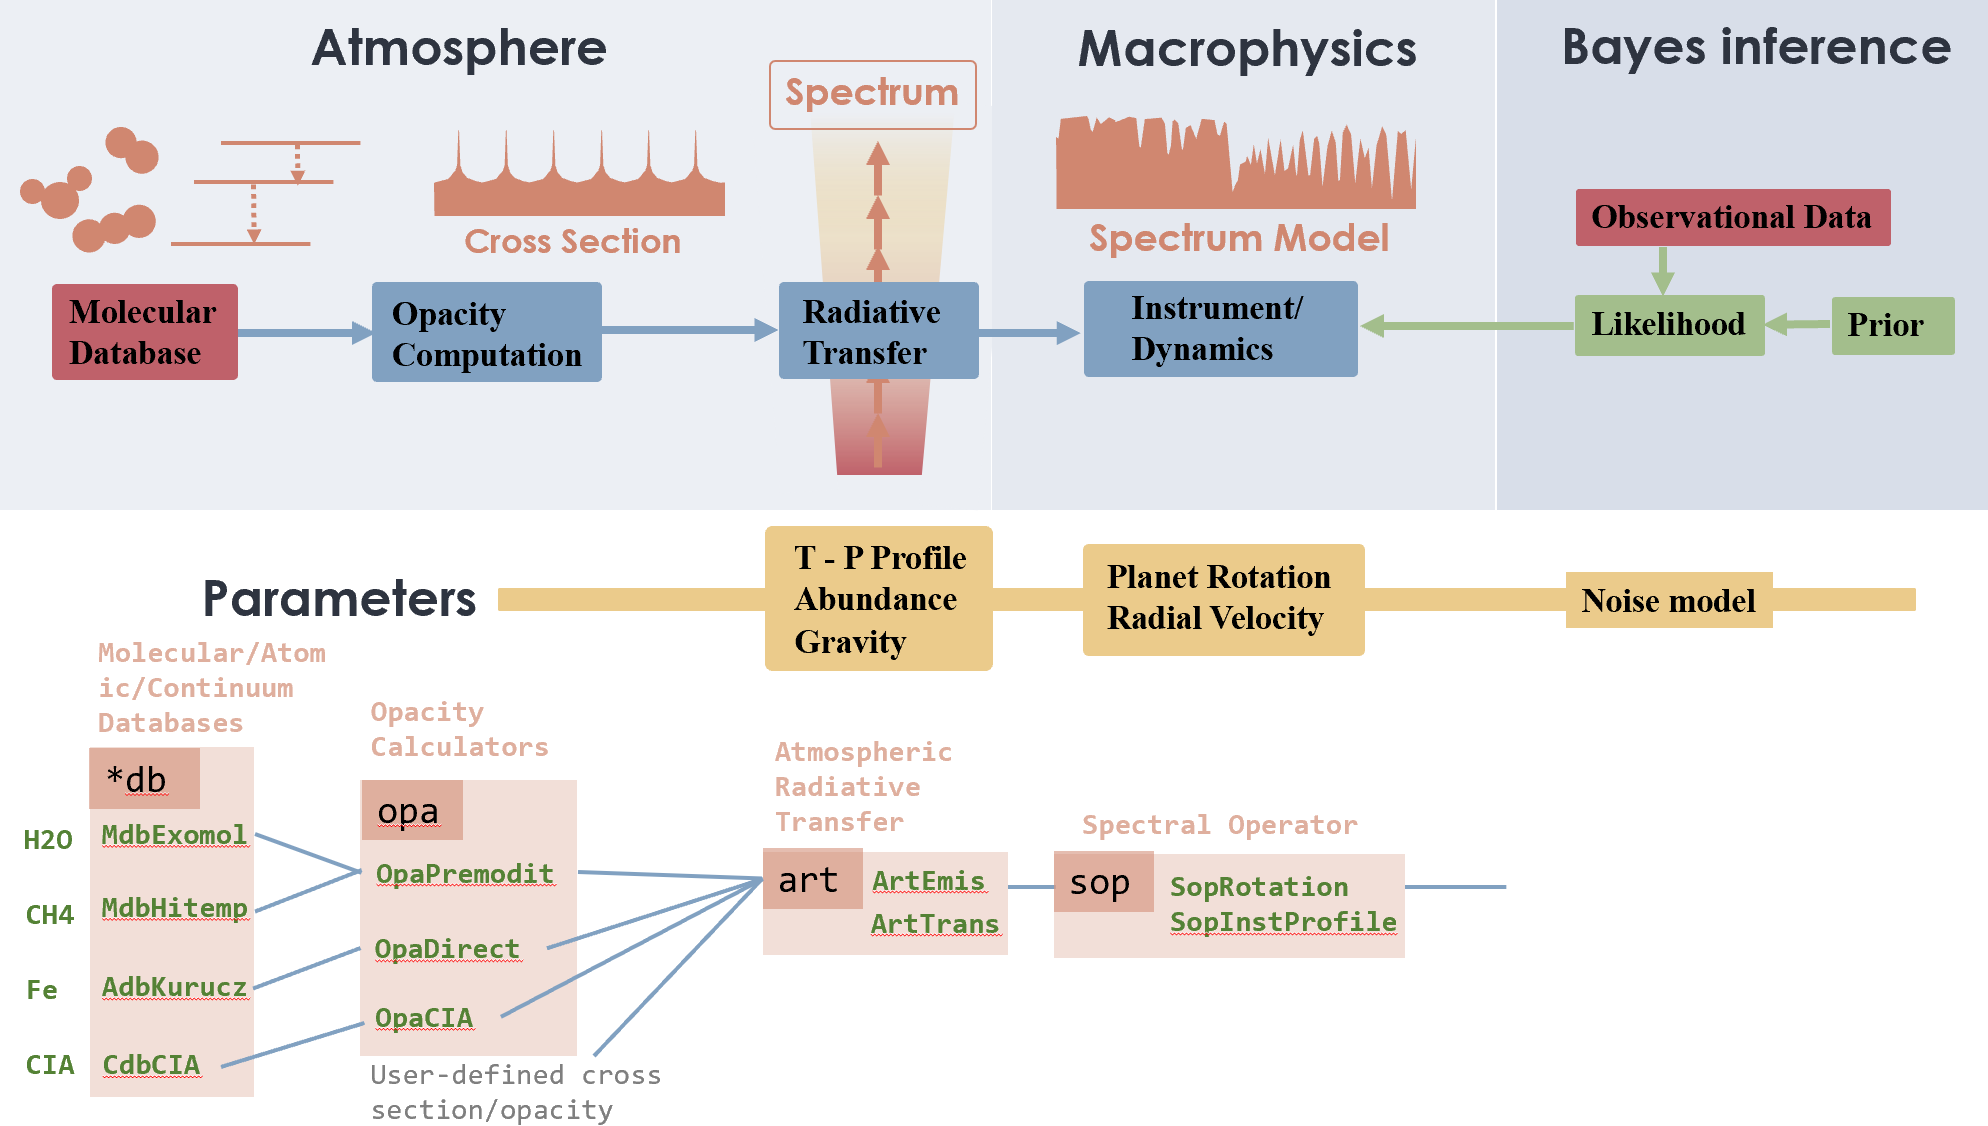

In [5]:
from IPython.display import Image
Image("../exojax.png")

In [6]:
Nx = 1500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 5.0,
                                np.max(wavd) + 5.0,
                                Nx,
                                unit="AA",
                                xsmode="premodit")

#Atmospheric setting by "art"
Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid=nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=100)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2

#instrumental setting
Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
We changed the policy of the order of wavenumber/wavelength grids
wavenumber grid should be in ascending order and now 
users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order
This might causes the bug if you update ExoJAX. 
Note that the older ExoJAX assumes ascending order as wavelength grid.
rtsolver:  fbased2st
Flux-based two-stream solver, isothermal layer (ExoJAX1, HELIOS-R1 like)


/home/exoplanet01/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=129859.29489937567
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Loading the databases, mdb for ExoMol/CH4 and cdb for CIA. Also, define opa for both databases. It takes ~ a few minites to initialize OpaPremodit (if you do not have the database, it takes more for downloading for the first time). Have a coffee and wait.

In [7]:
### CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('N=', len(mdb.nu_lines))
diffmode = 0
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=1.0)

## CIA setting
from exojax.spec import molinfo

cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4


/home/exoplanet01/exojax/src/exojax/utils/molname.py:178: FutureWarning: e2s will be replaced to exact_molname_exomol_to_simple_molname.
  warnings.warn(
/home/exoplanet01/exojax/src/exojax/utils/molname.py:65: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.", UserWarning)
/home/exoplanet01/exojax/src/exojax/utils/molname.py:65: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.", UserWarning)
/home/exoplanet01/exojax/src/exojax/spec/molinfo.py:28: UserWarning: exact molecule name is not Exomol nor HITRAN form.
  warnings.warn("exact molecule name is not Exomol nor HITRAN form.")
/home/exoplanet01/exojax/src/exojax/spec/molinfo.py:29: UserWarning: No molmass available
  warnings.warn("No molmass available", UserWarning)


Molecule:  CH4
Isotopologue:  12C-1H4
Background atmosphere:  H2
ExoMol database:  None
Local folder:  .database/CH4/12C-1H4/YT10to10
Transition files: 
	 => File 12C-1H4__YT10to10__06000-06100.trans
	 => File 12C-1H4__YT10to10__06100-06200.trans
#            i_upper    i_lower    A           nu_lines            gup    jlower    jupper    elower       eupper        Sij0
0            1033220    1024493    0.00024832  5999.9999849999995  50     12        12        6673.851806  12673.851791  6.323472505220992e-39
1            1064746    1291636    0.00039538  5999.999983999999   75     13        12        4933.785965  10933.785949  7.117220393764851e-35
2            1071252    1291978    0.0017425   6000.000033         75     13        12        6546.843546  12546.843579  1.2340167731327585e-37
3            1071787    1292023    0.00018938  6000.000016         75     13        12        6624.447597  12624.447613  9.197315036051529e-39
4            1117488    895034     0.0017477   6000.00

/home/exoplanet01/anaconda3/lib/python3.10/site-packages/radis-0.15-py3.10-linux-x86_64.egg/radis/api/exomolapi.py:607: AccuracyWarning: The default broadening parameter (alpha = 0.0488 cm^-1 and n = 0.4) are used for J'' > 16 up to J'' = 40
  warnings.warn(


N= 76483758
OpaPremodit: params automatically set.
Robust range: 397.77407283130566 - 1689.7679243628259 K
Tref changed: 296.0K->1153.6267095763965K


/home/exoplanet01/exojax/src/exojax/spec/opacalc.py:169: UserWarning: dit_grid_resolution is not None. Ignoring broadening_parameter_resolution.
  warnings.warn(


OpaPremodit: Tref_broadening is set to  774.5966692414833 K
# of reference width grid :  2
# of temperature exponent grid : 2


uniqidx: 100%|██████████| 1/1 [00:02<00:00,  2.08s/it]


Premodit: Twt= 461.3329793405918 K Tref= 1153.6267095763965 K
Making LSD:|####################| 100%
H2-H2


In [16]:
print(len(mdb.nu_lines))

76483758


Yeah, we have only 76,483,758 CH4 lines. Sets `sop`.

In [17]:
sop_rot = SopRotation(nu_grid,res,vsini_max=100.0)
sop_inst = SopInstProfile(nu_grid,res,vrmax=100.0)

/home/exoplanet01/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=129859.29489937567
  warnings.warn('Resolution may be too small. R=' + str(resolution),
/home/exoplanet01/exojax/src/exojax/utils/grids.py:145: UserWarning: Resolution may be too small. R=129859.29489937567
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Now we write the model, which is used in optimization.

In [18]:
#response and rotation settings
from exojax.utils.astrofunc import gravity_jupiter

def model_c(params,boost):
    Rp,RV,MMR_CH4,T0,alpha,vsini,RV=params*boost

    Tarr = art.powerlaw_temperature(T0, alpha)
    g = gravity_jupiter(Rp=Rp, Mp=Mp)  # gravity in the unit of Jupiter
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_xs(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    Frot = sop_rot.rigid_rotation(F0, vsini, u1=0.0, u2=0.0)
    Frot_inst = sop_inst.ipgauss(Frot, beta_inst)
    mu = sop_inst.sampling(Frot_inst, RV, nusd)
    return mu


In [19]:
#Rp,RV,MMR_CH4,T0,alpha,vsini, RV
boost=np.array([1.0,10.0,0.1,1000.0,1.e-3,10.0,10.0])
initpar=np.array([0.8,9.0,0.01,1200.0,0.1,17.0,0.0])/boost

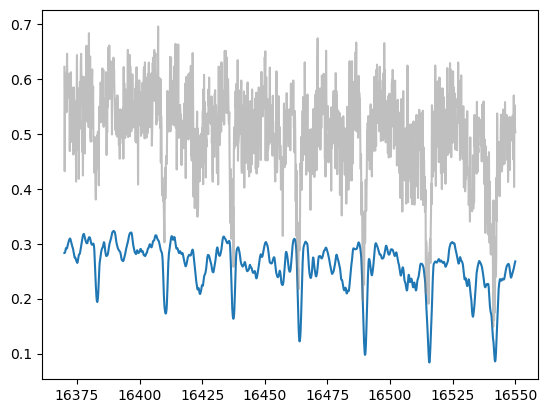

In [20]:
f = model_c(initpar,boost)
plt.plot(wavd[::-1],f)
plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")

Define the objective function by a L2 norm.

In [21]:
def objective(params):
    f=nflux-model_c(params,boost)
    g=jnp.dot(f,f)
    return g

### uses JAXOPT

In [51]:
import jaxopt

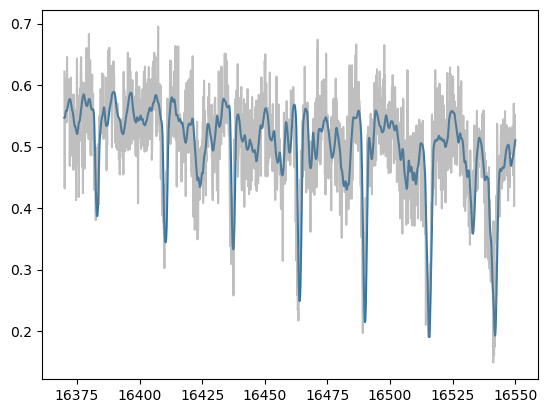

In [61]:
gd = jaxopt.GradientDescent(fun=objective, maxiter=100, stepsize=1.e-5)
resolution = gd.run(init_params=initpar)
params, state = resolution
model = model_c(params, boost)
resid = np.sqrt(np.sum((nflux - model)**2) / len(nflux))

plt.plot(wavd[::-1],model)
plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")

In [58]:
params

Array([7.94206986e-01, 9.00000000e-01, 7.46312047e-02, 1.21979899e+00,
       1.00000009e+02, 1.70000442e+00, 3.49558495e-05], dtype=float64)

### uses ADAM via JAXopt/Optax

In [62]:
from jaxopt import OptaxSolver
import optax

In [63]:
import tqdm
adam = OptaxSolver(opt=optax.adam(2.e-2), fun=objective)
state = adam.init_state(initpar)
params_a=np.copy(initpar)

params_adam=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params_a,state=adam.update(params_a,state)
    params_adam.append(params_a)

100%|██████████| 300/300 [00:07<00:00, 42.56it/s]


(-0.2, 0.2)

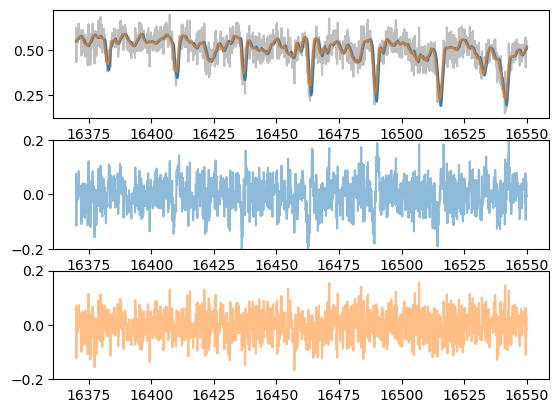

In [72]:
model_adam = model_c(params_a,boost)

fig=plt.figure()
ax = fig.add_subplot(311)
plt.plot(wavd[::-1],model, color="C0")
plt.plot(wavd[::-1],model_adam, color="C1")
plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")
ax = fig.add_subplot(312)
plt.plot(wavd[::-1],nflux-model,alpha=0.5,color="C0")
plt.ylim(-0.2,0.2)
ax = fig.add_subplot(313)
plt.plot(wavd[::-1],nflux-model_adam,alpha=0.5,color="C1")
plt.ylim(-0.2,0.2)



Here, we use `bayeux` as a wrapper of `optax`.

In [22]:
import bayeux as bx
import jax

normal_density = bx.Model(log_density=lambda x: -objective(x), test_point=initpar)

seed = jax.random.PRNGKey(0)

In [50]:
normal_density.optimize.optax_adam.get_kwargs()

{<function optax._src.alias.adam(learning_rate: Union[float, jax.Array, Callable[[Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, float, int]], Union[jax.Array, numpy.ndarray, numpy.bool_, numpy.number, float, int]]], b1: float = 0.9, b2: float = 0.999, eps: float = 1e-08, eps_root: float = 0.0, mu_dtype: Optional[Any] = None) -> optax._src.base.GradientTransformation>: {'b1': 0.9,
  'b2': 0.999,
  'eps': 1e-08,
  'eps_root': 0.0,
  'mu_dtype': None,
  'learning_rate': 0.1},
 'extra_parameters': {'chain_method': 'vectorized',
  'num_particles': 8,
  'num_iters': 1000,
  'apply_transform': True}}

In [35]:
epar = {'chain_method': 'vectorized','num_particles': 8,'num_iters': 10,'apply_transform': True}

In [48]:
opt_results = normal_density.optimize.optax_adam(seed=seed, learning_rate=1.e-2)

In [49]:
print(opt_results)

OptimizerResults(params=Array([[        nan, -1.54816334,         nan,         nan,         nan,
                nan,         nan],
       [-1.53939444,  0.91550192,  1.45048061, -0.83786368,  1.61348152,
         0.02948209, -8.99609765],
       [        nan, -0.95220913,         nan,         nan,         nan,
                nan,         nan],
       [        nan, -1.96014052,         nan,         nan,         nan,
                nan,         nan],
       [        nan, -0.34560645,         nan,         nan,         nan,
                nan,         nan],
       [        nan, -0.94483051,         nan,         nan,         nan,
                nan,         nan],
       [        nan, -1.34936884,         nan,         nan,         nan,
                nan,         nan],
       [-0.08328402, -0.20128299,  1.18719929,  1.29233165,  3.91762356,
         0.08986041,  0.97977645]], dtype=float64), state=ScaleByAdamState(count=Array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000], dtype=int3

In [47]:
normal_density.optimize.optax_adam.__dict__

{'log_density': <function __main__.<lambda>(x)>,
 'test_point': array([8.0e-01, 9.0e-01, 1.0e-01, 1.2e+00, 1.0e+02, 1.7e+00, 0.0e+00]),
 'transform_fn': <function bayeux._src.shared._nothing(x: Union[Mapping[str, jax.Array], NamedTuple]) -> Union[Mapping[str, jax.Array], NamedTuple]>,
 'inverse_transform_fn': <function oryx.core.interpreters.inverse.core.inverse.<locals>.wrapped(*args, **kwargs)>,
 'inverse_log_det_jacobian': None,
 'initial_state': None}